# IHT20H DS Test Task

## Set up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
import sklearn 
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

In [3]:
plt.rcParams.update({"figure.figsize": (20, 6)})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Preprocessing

In [4]:
events = pd.read_csv('int20h-ds-test-dataset.csv')

In [5]:
events['event_created_date'] = pd.to_datetime(events['event_created_date'])
events['ts'] = events['event_created_date'].values.astype(int) // 10 ** 9

In [6]:
events.head(5)

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model,ts
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""White"",""Year"":""2019"",""Temporary"":""false"",""Start Date"":"""",""End Date"":"""",""Rental state"":""""}",2022-01-16 17:03:04,android,samsung,SM-N975U,1642352584
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U,1642352867
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1,1642353385
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U,1642353862
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1",1642354491


**Коментар**

Помітимо, що подія, яка нас цікавить, *Subscription Premium Cancel*, з природи роботи підписки може відбутись тільки в користувачів, в яких цей преміум був. Враховуючи це, для того, щоб з'ясувати, які фічі впливають на цю подію, варто розглядати лише користувачів з підпискою

Зазначимо, що наявні дані містять події тільки за проміжок часу в три місяці. 

In [7]:
mindate = events.event_created_date.min()
maxdate = events.event_created_date.max()
timespan = maxdate - mindate

In [8]:
mindate, maxdate, timespan

(Timestamp('2022-01-15 02:06:43'),
 Timestamp('2022-04-16 20:50:39'),
 Timedelta('91 days 18:43:56'))

Тобто в користувачів, в яких підписка була оформлена до 2022-01-15, в датасеті не буде події оформлення підписки. Це означає, що преміум користувачів потрібно визначати не тільки по івенту оформлення підписки, а по всім наявним даним. А саме, преміум точно є користувачів, в яких
* є івент оформлення підписки
* є івент подовження підписки
* є івент скасування підписки
* в транзакції *Order* поле *Premium Membership* == True  

In [9]:
device_manufacture = dict(events[['device_model', 'device_manufacture']].values)
device_platform = dict(events[['device_model', 'event_platform']].values)

In [10]:
def nth_unique(n=1):
    def _nth_unique(x):
        uniq = list(set(x[x.notna()]))
        return uniq[n-1] if len(uniq) > n-1 else "None"
    return _nth_unique
    
users_info = events[['userid', 'user_state', 'device_model', 'event_name', 'ts']].groupby('userid').agg(
    user_state=pd.NamedAgg("user_state", lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None"),
    device1=pd.NamedAgg("device_model", nth_unique(n=1)),
    device2=pd.NamedAgg("device_model", nth_unique(n=2)),
    device3=pd.NamedAgg("device_model", nth_unique(n=3)),
    most_popular_event=pd.NamedAgg("event_name", lambda x: pd.Series.mode(x)[0] if pd.Series.mode(x)[0] != "Subscription Premium Cancel" else "None"),
    most_popular_device=pd.NamedAgg("device_model", lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None"),
    num_devices_and_nans=pd.NamedAgg("device_model", lambda x: len(pd.Series.unique(x))),
    last_event_ts=pd.NamedAgg("ts", pd.Series.max)
)

In [11]:
users_info['last_order_ts'] = events.loc[events['event_name'] == 'Order', ['userid', 'ts']].groupby('userid').max()['ts']

In [12]:
for i in range(1, 4):
    users_info[f'device{i}_manufacture'] = users_info[f'device{i}'].map(device_manufacture)
    users_info[f'device{i}_platform'] = users_info[f'device{i}'].map(device_platform)

In [13]:
users_info = users_info.astype(dtype={
   col : "category" for col in users_info.columns
})

In [14]:
users_events = events[['userid', 'event_name']].groupby(['userid', 'event_name']).agg(
    count_col=pd.NamedAgg(column="event_name", aggfunc='count'),
)
users_events = users_events.unstack(fill_value=0)
users_events.columns = [col[1] for col in users_events.columns]

In [15]:
users=users_events.join(users_info) 

In [16]:
users_premium_index = list(users[(users['Subscription Premium'] > 0) | 
                      (users['Subscription Premium Renew'] > 0) |
                      (users['Subscription Premium Cancel'] > 0)].index)

In [17]:
users_premium_index.extend(
    list(events.loc[events['event_attributes'].str.contains('{"Premium Membership":"True"}'), 'userid'].unique())
)

In [18]:
users_premium = users.loc[list(set(users_premium_index))]
users_premium

,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Cancel,Subscription Premium Renew,Transaction Refund,Wallet Opened,user_state,device1,device2,device3,most_popular_event,most_popular_device,num_devices_and_nans,last_event_ts,last_order_ts,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
f43c632c90fdf745918055860070afb1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,TX,SM-G965U,None,None,Add Payment Method Success,SM-G965U,2,1648854684,NaN,samsung,android,NaN,NaN,NaN,NaN
06e3b977d1d42365af2b77e958cf72b5,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,VA,"iPhone11,6",None,None,Account History Transaction Details,"iPhone11,6",2,1648398430,NaN,Apple,ios,NaN,NaN,NaN,NaN
2557cd4f51eecefae83b03a2731a6dad,17,0,0,0,3,0,0,1,0,3,0,0,0,2,0,1,0,1,1,0,0,0,6,NY,SM-A716U,None,None,Account History Transaction Details,SM-A716U,2,1649991097,1.648456e+09,samsung,android,NaN,NaN,NaN,NaN
81d7b7d89e06767d80a1aba25e4e3609,1,0,0,0,1,0,0,1,1,2,1,1,0,2,0,0,0,1,1,0,0,0,0,CA,"iPhone13,4",None,None,Calculator View,"iPhone13,4",2,1650106662,1.650107e+09,Apple,ios,NaN,NaN,NaN,NaN
c770656ba1992174f3b6619114830d16,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,TX,"iPhone8,2",None,None,Account History Transaction Details,"iPhone8,2",2,1647907141,NaN,Apple,ios,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c19ce293fc13c2bac4a88e330d452208,2,1,0,0,1,0,0,1,0,0,3,1,0,0,0,0,0,1,1,1,0,0,0,MD,"iPhone13,3",None,None,Chat Conversation Opened,"iPhone13,3",2,1650031741,NaN,Apple,ios,NaN,NaN,NaN,NaN
d5db42956fe1b7085365599f3937e0f8,0,0,0,0,0,0,0,0,0,0,0,0,0,54,0,0,0,0,0,0,1,0,2,TX,"iPhone13,4",None,None,Order,"iPhone13,4",2,1649659087,1.649659e+09,Apple,ios,NaN,NaN,NaN,NaN
ccfc868a3b67037fe3e90dfd1e867d2d,0,0,0,0,1,0,0,1,0,0,0,0,0,4,0,0,0,1,1,0,1,0,0,CA,"iPhone12,1",None,None,Order,"iPhone12,1",2,1649500952,1.649501e+09,Apple,ios,NaN,NaN,NaN,NaN


## Classification

In [19]:
X = users_premium.drop(columns=["Subscription Premium Cancel"])
y = (users_premium["Subscription Premium Cancel"] > 0).values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [21]:
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

In [22]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [23]:
y_test_pred = model.predict(X_test)

In [24]:
round(accuracy_score(y_test, y_test_pred), 2)

0.85

In [25]:
precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

(0.7538461538461538, 0.7777777777777778)

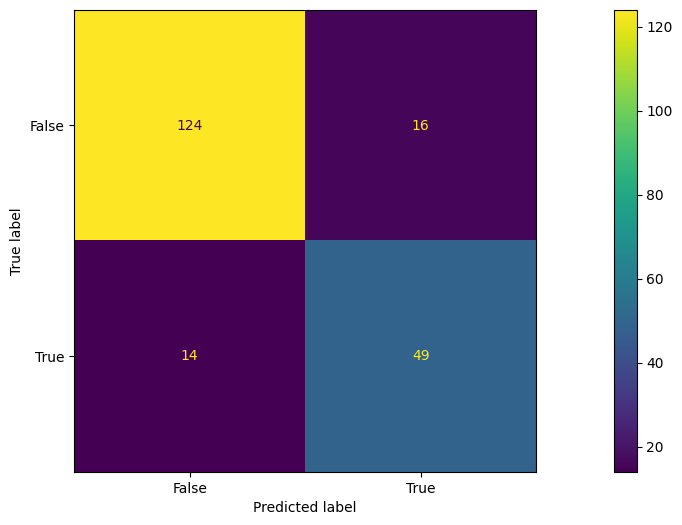

In [26]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.show()

## Features importance

Feature importance, прораховане за допомогою дерев, є доволі об'єктивним значенням, оскільки в основі принципу побудови дерев лежить виокремлення значущих features для найбільш гарного розділення простору features на підпростори класів. 

Оскільки побудована модель має доволі гарні accuracy, precision, recall scores, то можемо вважати, що отриманим даним щодо feature importance можна довіряти.

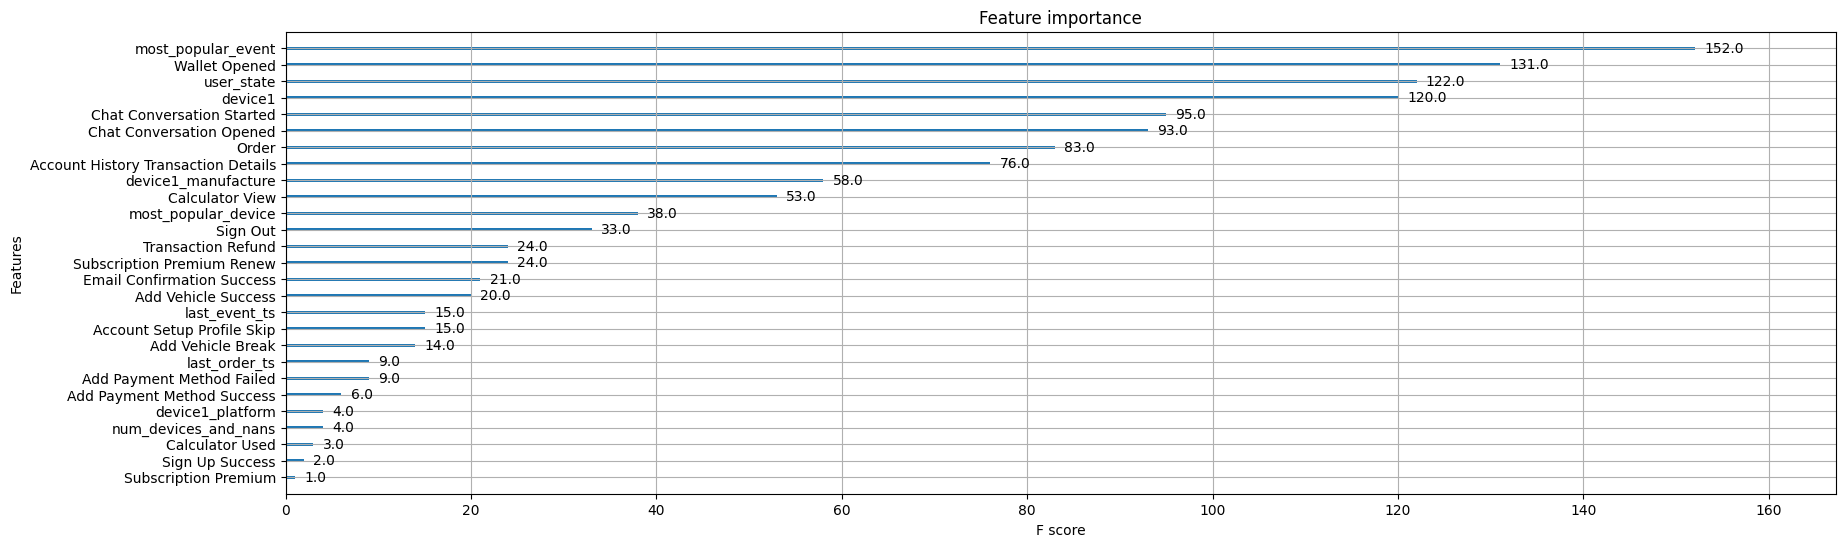

In [27]:
xgb.plot_importance(model)
# xgb.plot_importance(model, importance_type="cover", )
plt.show()

In [28]:
importances = pd.DataFrame.from_dict(dict(zip(X_train.columns, model.feature_importances_)), orient='index', columns=['Importance']).sort_values("Importance", ascending=False)
importances

,Importance
Chat Conversation Started,0.262566
Transaction Refund,0.136019
last_event_ts,0.065760
last_order_ts,0.053053
Account Setup Profile Skip,0.050779
Add Vehicle Break,0.037175
Add Payment Method Success,0.036438
Subscription Premium Renew,0.031974
device1_manufacture,0.029135
Add Payment Method Failed,0.028247


Chat Conversation Started, Transaction Refund є найбільш значущими features, далі йде значний спад і інші фічі мають доволі малий вплив на рішення моделі. 
Це можна пояснити тим, що ці дві фічі є тими, які відповідають за моменти, коли в користувача стаються проблеми: випадкове зняття грошей нікого не порадує, так само, як якісь проблеми, з-за яких треба звертатись до техпідтримки. 
Інші features зазвичай є подіями рутинного характеру, які в основному відображають звичайні операції користувача.